In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda
from modules.pytorch_models import Generator, Discriminator
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.neighbors import KernelDensity
import torch.nn as nn
import tqdm

In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

/Users/wfr5091/opt/anaconda3/envs/forward_v_inverse/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

In [5]:
def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')


def plot(points,dset, title,  thresh=0.01):

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax = ax.flatten()
    ax[0].set_title(title)
    ax[0].violinplot(points, np.arange(points.shape[1]))
    ax[0].set_xticks(np.arange(dset.size))
    ax[0].set_xticklabels(dset.elements)
    s = points.sum(axis=1)
    if np.max(s) - np.min(s) < 0.010:
        ax[1].hist(s, np.linspace(0.990, 1.010, 6))
    else:
        ax[1].hist(s)
    ax[2].hist(points.flatten())
    ne = (points > thresh).sum(axis=1)
    ax[3].hist(ne, np.arange(0, 12), width=0.80)
    plt.show()
    plt.close()


In [6]:
batch_size = 1 # 1000
minibatch_size = batch_size
prop_dim = y_scaled.shape[1]
latent_dim = 6
gen_in = latent_dim + prop_dim
hidden = gen_in*2
n_hidden = 3
gen_out = comp_dset.size
generator = Generator(gen_in,n_hidden,hidden,gen_out)
discriminator = Discriminator(gen_out+prop_dim,n_hidden,hidden,1)
optim_betas = (0.5, 0.999)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,betas=optim_betas)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,betas=optim_betas)
loss = nn.BCELoss()
d_steps = 1
g_steps = 1
prefix = 'Epoch'
cuda = check_cuda()
num_iterations = 1 # int(2e4)
log_interval = int(5e2)

In [7]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [8]:
def d_loop(dset=comp_dset, scaled_props = y_scaled):
  discriminator_optimizer.zero_grad()
  train_data, train_idx = dset.sample(batch_size)
  train_prop = scaled_props[train_idx]
  d_real_data = torch.from_numpy(train_data)
  d_real_prop = torch.from_numpy(train_prop)
  if cuda:
        d_real_data = d_real_data.cuda()
        d_real_prop = d_real_prop.cuda()
  
  true_discriminator_out = discriminator(d_real_data,d_real_prop)
  true_labels = torch.ones_like(true_discriminator_out)
  true_discriminator_loss = loss(true_discriminator_out, true_labels)


  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  with torch.no_grad():
        generated_data = generator(d_gen_input,d_gen_prop)
  
  generator_discriminator_out = discriminator(generated_data.detach(),d_gen_prop)
  generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros_like(generator_discriminator_out))
  discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
  discriminator_loss.backward()
  discriminator_optimizer.step()

In [9]:
def g_loop():
  generator_optimizer.zero_grad()
  
  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  generated_data = generator(d_gen_input,d_gen_prop)
  generator_discriminator_out = discriminator(generated_data,d_gen_prop)
  true_labels = torch.ones_like(generator_discriminator_out)
  generator_loss = loss(generator_discriminator_out, true_labels)
  generator_loss.backward()
  generator_optimizer.step()

In [10]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
        #prop_input = np.random.uniform(max,min,(minibatch_size,prop_dim)).astype('float32')
        prop_input = prop_sampler(minibatch_size)
        prop_input =  torch.from_numpy(prop_input)
        if cuda:
            gen_input = gen_input.cuda()
            prop_input = prop_input.cuda()
        g_fake_data = generator(gen_input,prop_input)
        return g_fake_data.cpu().numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

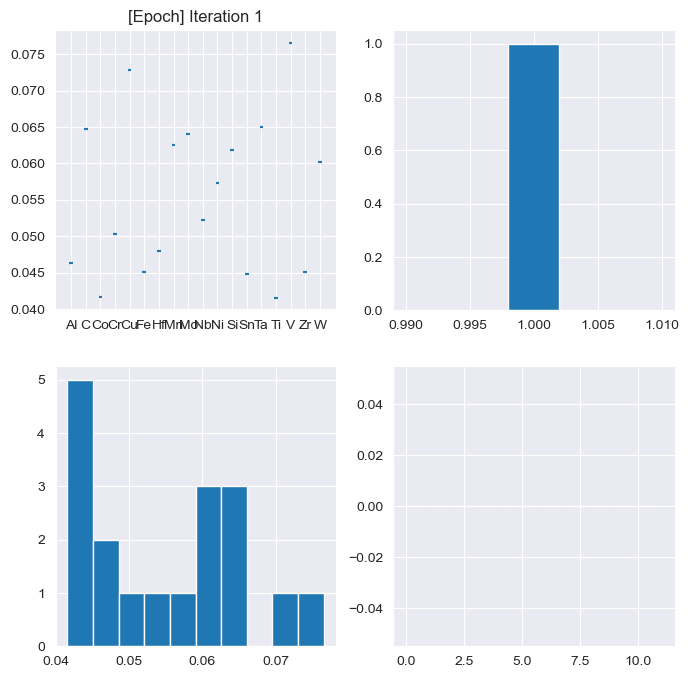

In [11]:
samples = []
for it in tqdm.notebook.tqdm(range(num_iterations), total=num_iterations):
    d_infos = []
    for d_index in range(d_steps):
        d_loop()
    for g_index in range(g_steps):
        g_loop()
    
    if it == 0 or (it + 1) % log_interval == 0:
        g_fake_data = g_sample()
        samples.append(g_fake_data)
        plot(g_fake_data, title='[{}] Iteration {}'.format(prefix, it+1),dset = comp_dset)
        train_epoch = it+1
# model_path = 'saved_models'
# model_scripted = torch.jit.script(generator.cpu())
# model_scripted.save(os.path.join(model_path, 'GAN_generator_{}_dims.pt'.format(latent_dim)))

additional analysis

In [12]:
weights = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print( f'model has {weights} trainable weights' )

model has 592 trainable weights


In [13]:
with torch.no_grad():
    gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
    prop_input = prop_sampler(minibatch_size)
    prop_input = torch.from_numpy(prop_input)

%timeit g_fake_data = generator(gen_input, prop_input)

44.7 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
